In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

# hyperparameters
batch_size = 64 #how many examples to process together at once
block_size = 19 #context length
max_iters = 16000
eval_interval = 400
learning_rate = 0.00008 #for two layer
#learning_rate = 0.0004
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 512
n_head = 3
n_layer = 2
dropout = 0.2

In [3]:
dataset = set()
with open('addition.txt','w') as f:
    for i in range(2000000):
        a = random.randint(10000,99999)
        b = random.randint(10000,99999)
        c = a+b
        f.write(f'{a}+{b}={c}%')

with open('addition.txt','r') as f:
    for line in f:
        dataset.add(line)

vocab_size = 13

In [4]:
encode = lambda s: [10 if c == '+' else 11 if c == '=' else 12 if c == '%' else int(c) for c in s]
decode = lambda l: (['+' if c == 10 else '=' if c == 11 else '\n' if c == 12 else c.item() for c in l])
print(encode('12323+12321=34311'))

def real_decode(l):
  return ''.join(map(str,decode(l)))

[1, 2, 3, 2, 3, 10, 1, 2, 3, 2, 1, 11, 3, 4, 3, 1, 1]


In [5]:
max_length = max(len(encode(line)) for line in dataset)
tensor_np = np.full((len(dataset), max_length), 12, dtype=int)

for i, line in enumerate(dataset):
    encoded_line = encode(line)
    tensor_np[i, :len(encoded_line)] = encoded_line

data = torch.tensor(tensor_np, dtype=torch.long)

print("shape:", data.shape)

shape: torch.Size([1, 37210935])


In [6]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]
print(train_data.shape,val_data.shape)

torch.Size([0, 37210935]) torch.Size([1, 37210935])


In [7]:
train_data[0]

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [ ]:
val_data[0]

tensor([ 9,  3,  3,  9,  0, 10,  9,  3,  6,  9,  4, 11,  1,  8,  7,  0,  8,  4,
        12])

In [ ]:
for t in range(3):
    print(f"example {t+1}")
    for x in range(6):
        print(f"we want to use {real_decode(train_data[t][:12+x])} to predict {train_data[t][12+x]}")

example 1
we want to use 10565+59540= to predict 7
we want to use 10565+59540=7 to predict 0
we want to use 10565+59540=70 to predict 1
we want to use 10565+59540=701 to predict 0
we want to use 10565+59540=7010 to predict 5
we want to use 10565+59540=70105 to predict 12
example 2
we want to use 30252+24971= to predict 5
we want to use 30252+24971=5 to predict 5
we want to use 30252+24971=55 to predict 2
we want to use 30252+24971=552 to predict 2
we want to use 30252+24971=5522 to predict 3
we want to use 30252+24971=55223 to predict 12
example 3
we want to use 92985+75731= to predict 1
we want to use 92985+75731=1 to predict 6
we want to use 92985+75731=16 to predict 8
we want to use 92985+75731=168 to predict 7
we want to use 92985+75731=1687 to predict 1
we want to use 92985+75731=16871 to predict 6


In [8]:
#IMPORTANT! This bug cost me an hour. the -1 is needed because targets need to be shifted back by 1
xb,yb = get_batch("train")
print("inputs:")
print(xb[:,-8:-1])
print("targets")
print(yb)

NameError: name 'get_batch' is not defined

In [ ]:
# hyperparameters
batch_size = 64 #how many examples to process together at once
block_size = 19 #context length
max_iters = 16000
eval_interval = 400
learning_rate = 0.00008 #for two layer
#learning_rate = 0.0004
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 512
n_head = 3
n_layer = 2
dropout = 0.2

train_losses = []
val_losses = []

def get_batch(split):
    data = train_data if split=="train" else val_data
    ix = torch.randint(len(data),(batch_size,))
    x = torch.stack([data[i] for i in ix]).to(device)
    y = torch.stack([data[i][12:] for i in ix]).to(device)
    return x,y


@torch.no_grad()
def estimate_loss():
    out = {}
    m.eval()
    for split in ['train','val']:
        losses = torch.zeros(eval_iters).to(device)
        for k in range(eval_iters):
            X,Y = get_batch(split)
            logits,loss = m(X,Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()
    return out


class FeedForward(nn.Module):
    def __init__(self,n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd,4*n_embd),
            nn.ReLU(),
            nn.Linear(4*n_embd,n_embd),
            nn.Dropout(dropout)
        )

    def forward(self,x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self,n_embd,n_head):
        # n_embd = embedding dimension, n_head = num of heads
        super().__init__()
        head_size = n_embd // n_head
        self.sa = ParallelMultiHeadAttention(n_head,head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self,x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class ParallelMultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.total_head_size = num_heads * head_size #this is just equal to n_embd

        # Combined linear layers for all heads
        self.key = nn.Linear(n_embd, self.total_head_size, bias=False)
        self.query = nn.Linear(n_embd, self.total_head_size, bias=False)
        self.value = nn.Linear(n_embd, self.total_head_size, bias=False)

        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(self.total_head_size, n_embd)

    def forward(self, x):
        B, T, C = x.shape  # C = n_embd

        # Generate key, query, and value for all heads at once
        k = self.key(x).view(B, T, self.num_heads, self.head_size).transpose(1, 2)  # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.num_heads, self.head_size).transpose(1, 2)  # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.num_heads, self.head_size).transpose(1, 2)  # (B, nh, T, hs)

        # Compute attention scores
        wei = q @ k.transpose(-2, -1) * (self.head_size ** -0.5)  # (B, nh, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, nh, T, T)
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        # Apply attention to values
        out = wei @ v  # (B, nh, T, hs)
        out = out.transpose(1, 2).contiguous().view(B, T, self.total_head_size)  # (B, T, nh*hs)

        # Final projection
        out = self.proj(out)
        out = self.dropout(out)
        return out


class DecoderLM(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size,n_embd)
        self.position_embedding_table = nn.Embedding(block_size,n_embd)
        self.blocks = nn.Sequential(
            *[Block(n_embd,n_head=n_head) for _ in range(n_layer)]
        )
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd,vocab_size)

    def forward(self,idx,targets=None):
        B,T = idx.shape

        token_emb = self.token_embedding_table(idx) # shape of (batch_size,block_size,n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T,device=device))
        x = token_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            #IMPORTANT CHANGE
            #THE ":-1" is KEY
            logits = logits[:,-8:-1,:] #only calculate loss for the answer, not the random numbers
            #print(B,T,C)
            #print(logits.shape)
            logits = logits.reshape(B*7,C)
            targets = targets.view(B*7)
            loss = F.cross_entropy(logits,targets)

        return logits,loss

    def generate(self,idx,max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:,-block_size:]
            logits,loss = self(idx_cond)
            logits = logits[:,-1,:]
            probs = F.softmax(logits,dim=-1)
            idx_next = torch.multinomial(probs,num_samples=1)
            if idx_next == 12:
                break
            idx = torch.cat((idx,idx_next),dim=1)
        return idx

m = DecoderLM().to(device)

optimizer = optim.AdamW(m.parameters(),
                        lr=learning_rate,
                        weight_decay=0.1,
                        betas=(0.9, 0.98))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))

text= """
for iter in range(max_iters):
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])


    xb,yb = get_batch('train')
    logits,loss = m(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    scheduler.step()
"""

NameError: name 'torch' is not defined

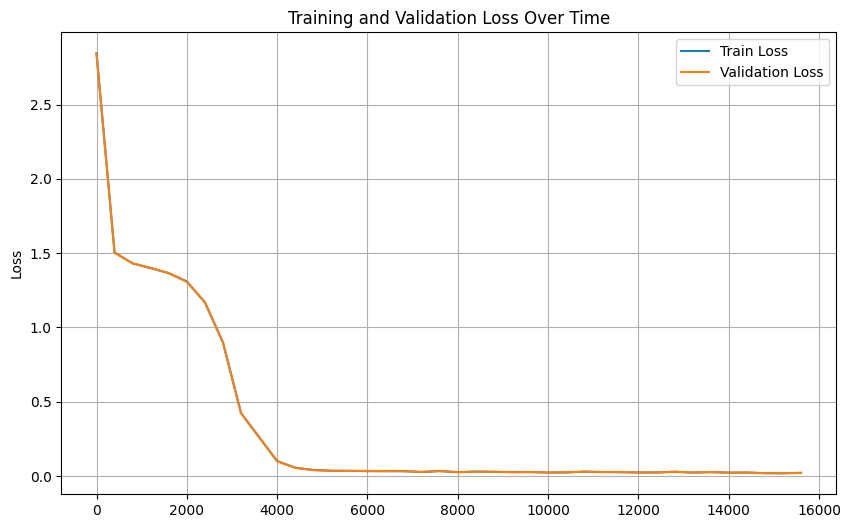

In [29]:
train_losses_np = np.array([loss.cpu().numpy() for loss in train_losses])
val_losses_np = np.array([loss.cpu().numpy() for loss in val_losses])

plt.figure(figsize=(10, 6))
plt.plot(range(0, max_iters, eval_interval), train_losses_np, label='Train Loss')
plt.plot(range(0, max_iters, eval_interval), val_losses_np, label='Validation Loss')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from google.colab import files

torch.save(m.state_dict(), 'my_model.pth')
files.download('my_model.pth')

In [31]:
a = 23429
b = 92345
context = torch.tensor([encode(str(a)+'+'+str(b)+'=')],dtype = torch.long,device = device)
print('model answer: ',''.join(map(str,decode(m.generate(context,max_new_tokens=20)[0]))))
print('actual answer: ',a+b)

model answer:  23429+92345=115774
actual answer:  115774


In [12]:
estimate_loss()

{'train': tensor(0.0180, device='cuda:0'),
 'val': tensor(0.0190, device='cuda:0')}

In [13]:
context = torch.tensor([encode('12345+12345=')],dtype = torch.long,device = device)
print(''.join(map(str,decode(m.generate(context,max_new_tokens=20)[0]))))

12345+12345=24690

7910836955518
